### Part 4 Sentiment Analysis on Beatles song lyrics - using multiple methods

0. The Spotify dataset produces a 'Valence' score for each song that considers not only lyrics but also the notes of music. I'm using this as the standard for comparison since Spotify is... well... Spotify. 
1. Bag of words approach - VADER (Valence Aware Dictionary and sEntiment Reasoner) using 'vader_lexicon' from the Natural Language Toolkit Python package. This is a "conventional" approach to sentiment analysis. The values generated by this model are: Vaders_neg	Vaders_neu	Vaders_pos	Vaders_compound
2. Roberta Pretrained Model from Huggingface.  The Roberta Pretrained Model is trained on a large corpus of data. Transformer model accounts for the words but also the context related to other words.
The values generated by this model are:  'roberta_neg', 'roberta_neu', and 'roberta_pos'
3. Huggingface 'Pipeline' - Huggingface will select a pretrained model by itself. This is a black-box - more or less - but incredibly easy to implement, I just set one parameter, sent_pipeline = pipeline("sentiment-analysis") and pointed to my corpus of 'lyrics'. This label generates values called sentiment_label and sentiment_score.
4. I tried a highly tuned model ("amanda-cristina/finetuning-sentiment-model-4500-lyrics") from Huggingface that is trained specifically on song lyrics. It returns a labeled value called 'FinetunedSentiment' that unfortunately only returns a polarity logit assignment 'positive' or 'negative'. I wish it contained more variance to analyze.  




To do:
add wordcount to each record

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')


import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Set the NLTK data path
nltk.data.path.append("/path/to/nltk_data")

# Download the required NLTK data to get some common lexicons
nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

sia = SentimentIntensityAnalyzer()


import torch
from scipy.special import softmax

from transformers import AutoTokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rob\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [62]:
##Step 0: Red in data and nltk

df = pd.read_pickle('BeatlesSongsQCd.pkl')


# Reset the index and create a new column 'id' this will be needed to match back dataframes later
df.reset_index(inplace=True)
df.rename(columns={'index': 'Id'}, inplace=True)

#I averaged the popularity and score from Spotify by song because of rereleases of songs like on compilations, soundtracks, etc.
df['popularity'] = df['avg_popularity'].round().astype(int)





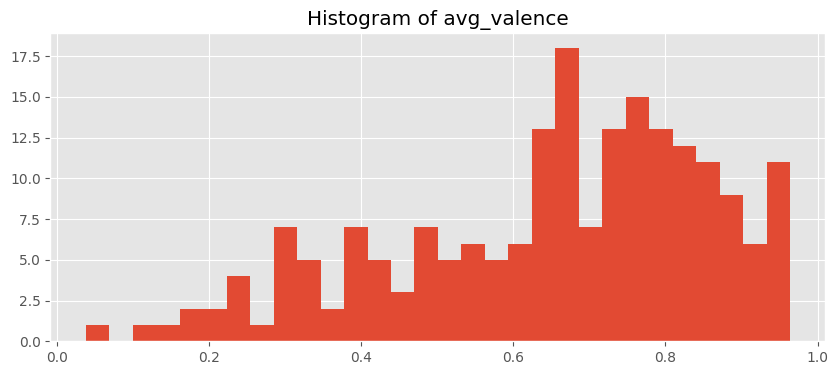

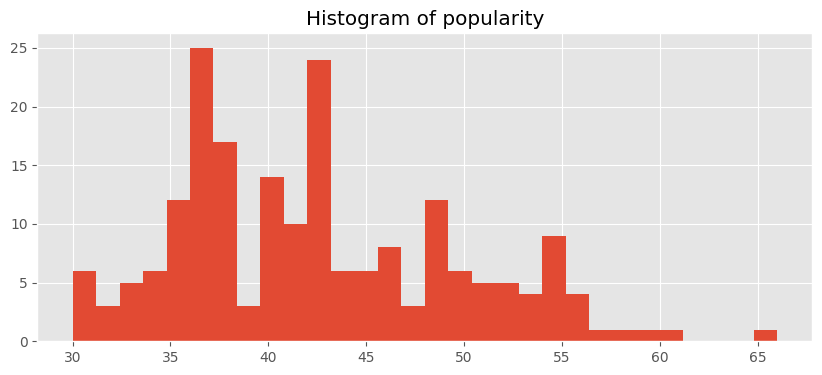

In [8]:
for col in [ 'avg_valence', 'popularity']:
    plt.figure(figsize=(10,4))
    plt.hist(df[col].dropna(), bins=30)  # dropna to avoid error if there are NaNs
    plt.title(f'Histogram of {col}')
    plt.show()

    

In [9]:
example = df['lyrics'].iloc[40]
print(example)

tokens = nltk.word_tokenize(example)
tokens[:10]

tagged = nltk.pos_tag(tokens)
tagged[:10]

Asked a girl what she wanted to be She said baby, can't you see I wanna be famous, a star on the screen But you can do something in between  Baby you can drive my car Yes I'm gonna be a star Baby you can drive my car And baby I love you  I told a girl that my prospects were good And she said baby, it's understood Working for peanuts is all very fine But I can show you a better time  Baby you can drive my car Yes I'm gonna be a star Baby you can drive my car And baby I love you  Beep beep'm beep beep yeah  Baby you can drive my car Yes I'm gonna be a star Baby you can drive my car And baby I love you  I told a girl I can start right away And she said listen babe I got something to say I got no car and it's breaking my heart But I've found a driver and that's a start  Baby you can drive my car Yes I'm gonna be a star Baby you can drive my car And baby I love you  Beep beep'm beep beep yeah Beep beep'm beep beep yeah Beep beep'm beep beep yeah Beep beep'm beep beep yeah 


[('Asked', 'VBN'),
 ('a', 'DT'),
 ('girl', 'NN'),
 ('what', 'WP'),
 ('she', 'PRP'),
 ('wanted', 'VBD'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('She', 'PRP'),
 ('said', 'VBD')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Asked/VBN
  a/DT
  girl/NN
  what/WP
  she/PRP
  wanted/VBD
  to/TO
  be/VB
  She/PRP
  said/VBD
  baby/NN
  ,/,
  ca/MD
  n't/RB
  you/PRP
  see/VBP
  I/PRP
  wan/VBP
  na/RB
  be/VB
  famous/JJ
  ,/,
  a/DT
  star/NN
  on/IN
  the/DT
  screen/NN
  But/CC
  you/PRP
  can/MD
  do/VB
  something/NN
  in/IN
  between/IN
  (PERSON Baby/NNP)
  you/PRP
  can/MD
  drive/VB
  my/PRP$
  car/NN
  Yes/UH
  I/PRP
  'm/VBP
  gon/VBG
  na/TO
  be/VB
  a/DT
  star/NN
  Baby/NNP
  you/PRP
  can/MD
  drive/VB
  my/PRP$
  car/NN
  And/CC
  baby/NN
  I/PRP
  love/VBP
  you/PRP
  I/PRP
  told/VBD
  a/DT
  girl/NN
  that/WDT
  my/PRP$
  prospects/NNS
  were/VBD
  good/JJ
  And/CC
  she/PRP
  said/VBD
  baby/NN
  ,/,
  it/PRP
  's/VBZ
  understood/JJ
  Working/NNP
  for/IN
  peanuts/NNS
  is/VBZ
  all/DT
  very/RB
  fine/JJ
  But/CC
  I/PRP
  can/MD
  show/VB
  you/PRP
  a/DT
  better/JJR
  time/NN
  Baby/IN
  you/PRP
  can/MD
  drive/VB
  my/PRP$
  car/NN
  Yes/UH
  I/PRP
  'm/VBP
  gon/VBG
  na/TO
 

In [11]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['lyrics']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/198 [00:00<?, ?it/s]

In [12]:
res

{0: {'neg': 0.049, 'neu': 0.819, 'pos': 0.133, 'compound': 0.9313},
 1: {'neg': 0.062, 'neu': 0.801, 'pos': 0.137, 'compound': 0.9443},
 2: {'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.9747},
 3: {'neg': 0.048, 'neu': 0.644, 'pos': 0.308, 'compound': 0.9839},
 4: {'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'compound': 0.9663},
 5: {'neg': 0.008, 'neu': 0.457, 'pos': 0.534, 'compound': 0.9996},
 6: {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'compound': 0.997},
 7: {'neg': 0.037, 'neu': 0.912, 'pos': 0.051, 'compound': 0.1531},
 8: {'neg': 0.025, 'neu': 0.743, 'pos': 0.233, 'compound': 0.9883},
 9: {'neg': 0.061, 'neu': 0.729, 'pos': 0.21, 'compound': 0.9901},
 10: {'neg': 0.065, 'neu': 0.883, 'pos': 0.052, 'compound': -0.25},
 11: {'neg': 0.074, 'neu': 0.71, 'pos': 0.216, 'compound': 0.9831},
 12: {'neg': 0.093, 'neu': 0.84, 'pos': 0.066, 'compound': 0.0005},
 13: {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'compound': 0.9957},
 14: {'neg': 0.033, 'neu': 0.849, 'pos': 0.118, 'compound

In [13]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})

vaders.rename(columns={'neg': 'Vaders_neg', 'neu': 'Vaders_neu', 'pos': 'Vaders_pos', 'compound': 'Vaders_compound'}, inplace=True)



vaders = vaders.merge(df, how='left')

In [14]:
vaders.tail()
##new  columns: neg	neu	pos	compound	


,Id,Vaders_neg,Vaders_neu,Vaders_pos,Vaders_compound,song,core_catalogue_releases,songwriters,lead_vocals,year,...,Canonical_album,Year_y,first_vocalist,Paul_Song,John_Song,George_Song,Ringo_Song,cover,Era,popularity
193,210,0.000,1.000,0.000,0.0000,Your Mother Should Know,Magical Mystery Tour,Lennon McCartney,McCartney,1967,...,Magical Mystery Tour,1967.0,McCartney,1,0,0,0,0,Experimental,36
194,211,0.140,0.713,0.147,0.3527,You're Going to Lose That Girl,Help!,Lennon McCartney,Lennon,1965,...,Help!,1965.0,Lennon,0,1,0,0,0,Beatlemania,56
195,212,0.076,0.712,0.213,0.9717,You've Got to Hide Your Love Away,Help!,Lennon McCartney,Lennon,1965,...,Help!,1965.0,Lennon,0,1,0,0,0,Beatlemania,49
196,213,0.087,0.635,0.278,0.9896,Real Love,Anthology 2,Lennon,Lennon,1996,...,Anthology 2,1995.0,Lennon,0,1,0,0,0,Group of Solo Artists,53
197,214,0.017,0.674,0.309,0.9927,Free as a Bird,Anthology 1,Lennon McCartney Harrison Starkey,Lennon (with McCartney and Harrison),1995,...,Anthology 1,1995.0,Lennon,0,1,0,0,0,Group of Solo Artists,52


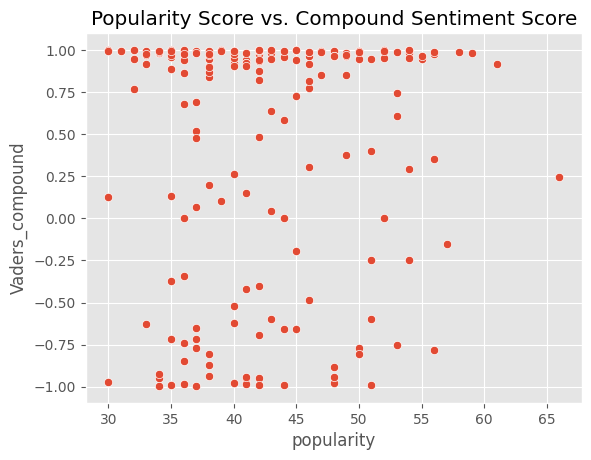

In [15]:
# Create a scatterplot
ax = sns.scatterplot(data=vaders, x='popularity', y='Vaders_compound')
ax.set_title('Popularity Score vs. Compound Sentiment Score')

# Show the plot
plt.show()

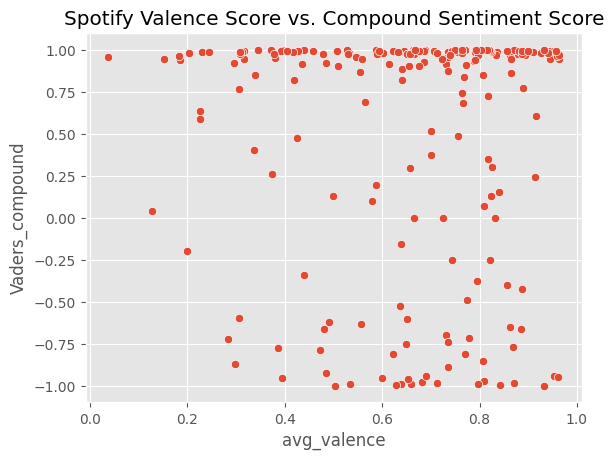

In [16]:
ax = sns.scatterplot(data=vaders, x='avg_valence', y='Vaders_compound')
ax.set_title('Spotify Valence Score vs. Compound Sentiment Score')
plt.show()

In [17]:
correlation = vaders['avg_valence'].corr(vaders['Vaders_compound'])
print("Correlation between 'popularity' and 'compound':", correlation)



Correlation between 'popularity' and 'compound': -0.03380954367397079


In [18]:
##Wow - there is almost no ccrrrelation between the Spotify valence score and the compound score from song lyrics.

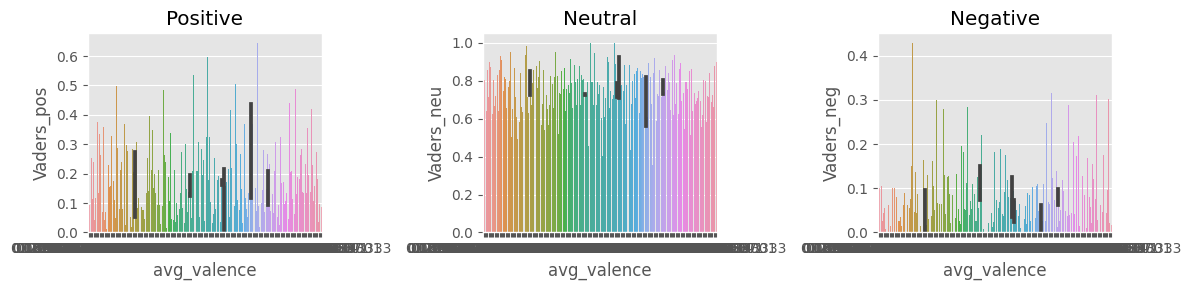

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='avg_valence', y='Vaders_pos', ax=axs[0])
sns.barplot(data=vaders, x='avg_valence', y='Vaders_neu', ax=axs[1])
sns.barplot(data=vaders, x='avg_valence', y='Vaders_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

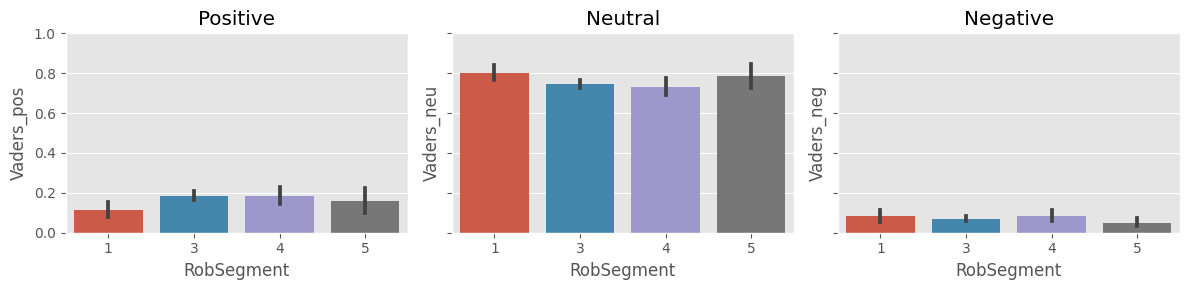

In [20]:


# Create subplots with a shared y-axis
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# Plot the barplots
sns.barplot(data=vaders, x='RobSegment', y='Vaders_pos', ax=axs[0])
sns.barplot(data=vaders, x='RobSegment', y='Vaders_neu', ax=axs[1])
sns.barplot(data=vaders, x='RobSegment', y='Vaders_neg', ax=axs[2])

# Set titles for each subplot
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

# Set y-axis limits for all subplots
min_value = vaders[['Vaders_pos', 'Vaders_neu', 'Vaders_neg']].min().min()
max_value = vaders[['Vaders_pos', 'Vaders_neu', 'Vaders_neg']].max().max()
for ax in axs:
    ax.set_ylim(min_value, max_value)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [21]:
##my personal preferences also do not align to VADER valence from lyrics
 

### Part 2 - Roberta Pretrained Model
Use a model trained of a large corpus of data.
Transformer model accounts for the words but also the context related to other words.

In [22]:
vaders


,Id,Vaders_neg,Vaders_neu,Vaders_pos,Vaders_compound,song,core_catalogue_releases,songwriters,lead_vocals,year,...,Canonical_album,Year_y,first_vocalist,Paul_Song,John_Song,George_Song,Ringo_Song,cover,Era,popularity
0,0,0.049,0.819,0.133,0.9313,Across the Universe,Let It Be Past Masters,Lennon McCartney,Lennon,1969,...,Let It Be,11970.0,Lennon,0,1,0,0,0,Group of Solo Artists,42
1,1,0.062,0.801,0.137,0.9443,Act Naturally,Help!,Johnny Russell Voni Morrison †,Starr,1965,...,Help!,1965.0,Starr,0,0,0,1,1,Beatlemania,51
2,2,0.000,0.796,0.204,0.9747,All I've Got to Do,With the Beatles,Lennon McCartney,Lennon,1963,...,With The Beatles,1963.0,Lennon,0,1,0,0,0,Beatlemania,54
3,3,0.048,0.644,0.308,0.9839,All My Loving,With the Beatles,Lennon McCartney,McCartney,1963,...,With The Beatles,1963.0,McCartney,1,0,0,0,0,Beatlemania,43
4,4,0.000,0.791,0.209,0.9663,All Together Now,Yellow Submarine,Lennon McCartney,McCartney (with Lennon),1969,...,Yellow Submarine,1969.0,McCartney,1,0,0,0,0,Group of Solo Artists,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,210,0.000,1.000,0.000,0.0000,Your Mother Should Know,Magical Mystery Tour,Lennon McCartney,McCartney,1967,...,Magical Mystery Tour,1967.0,McCartney,1,0,0,0,0,Experimental,36
194,211,0.140,0.713,0.147,0.3527,You're Going to Lose That Girl,Help!,Lennon McCartney,Lennon,1965,...,Help!,1965.0,Lennon,0,1,0,0,0,Beatlemania,56
195,212,0.076,0.712,0.213,0.9717,You've Got to Hide Your Love Away,Help!,Lennon McCartney,Lennon,1965,...,Help!,1965.0,Lennon,0,1,0,0,0,Beatlemania,49
196,213,0.087,0.635,0.278,0.9896,Real Love,Anthology 2,Lennon,Lennon,1996,...,Anthology 2,1995.0,Lennon,0,1,0,0,0,Group of Solo Artists,53


In [23]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
##MODEL = f"amanda-cristina/finetuning-sentiment-model-4500-lyrics"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)



In [24]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.012294031, 'roberta_neu': 0.17058106, 'roberta_pos': 0.81712496}


In [25]:
scores

array([0.01229403, 0.17058106, 0.81712496], dtype=float32)

In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [27]:
###select the right dataframe for scoring against the lyrics

res = {}
for i, row in tqdm(vaders.iterrows(), total=len(vaders)):
    try:
        text = row['lyrics']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broken for id {myid}')

  0%|          | 0/198 [00:00<?, ?it/s]

In [28]:
res

{0: {'vader_neg': 0.049,
  'vader_neu': 0.819,
  'vader_pos': 0.133,
  'vader_compound': 0.9313,
  'roberta_neg': 0.098181084,
  'roberta_neu': 0.5144626,
  'roberta_pos': 0.38735628},
 1: {'vader_neg': 0.062,
  'vader_neu': 0.801,
  'vader_pos': 0.137,
  'vader_compound': 0.9443,
  'roberta_neg': 0.16150792,
  'roberta_neu': 0.48108742,
  'roberta_pos': 0.3574046},
 2: {'vader_neg': 0.0,
  'vader_neu': 0.796,
  'vader_pos': 0.204,
  'vader_compound': 0.9747,
  'roberta_neg': 0.057021633,
  'roberta_neu': 0.55751735,
  'roberta_pos': 0.38546106},
 3: {'vader_neg': 0.048,
  'vader_neu': 0.644,
  'vader_pos': 0.308,
  'vader_compound': 0.9839,
  'roberta_neg': 0.020825606,
  'roberta_neu': 0.29995474,
  'roberta_pos': 0.6792196},
 4: {'vader_neg': 0.0,
  'vader_neu': 0.791,
  'vader_pos': 0.209,
  'vader_compound': 0.9663,
  'roberta_neg': 0.0066666026,
  'roberta_neu': 0.14941642,
  'roberta_pos': 0.84391695},
 5: {'vader_neg': 0.008,
  'vader_neu': 0.457,
  'vader_pos': 0.534,
  'vader

In [29]:
##combine res with df
roberta = pd.DataFrame(res).T
roberta = roberta.reset_index().rename(columns={'index': 'Id'})
roberta = roberta.merge(df, how='left')

roberta.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,song,core_catalogue_releases,...,Canonical_album,Year_y,first_vocalist,Paul_Song,John_Song,George_Song,Ringo_Song,cover,Era,popularity
0,0,0.049,0.819,0.133,0.9313,0.098181,0.514463,0.387356,Across the Universe,Let It Be Past Masters,...,Let It Be,11970.0,Lennon,0,1,0,0,0,Group of Solo Artists,42
1,1,0.062,0.801,0.137,0.9443,0.161508,0.481087,0.357405,Act Naturally,Help!,...,Help!,1965.0,Starr,0,0,0,1,1,Beatlemania,51
2,2,0.000,0.796,0.204,0.9747,0.057022,0.557517,0.385461,All I've Got to Do,With the Beatles,...,With The Beatles,1963.0,Lennon,0,1,0,0,0,Beatlemania,54
3,3,0.048,0.644,0.308,0.9839,0.020826,0.299955,0.679220,All My Loving,With the Beatles,...,With The Beatles,1963.0,McCartney,1,0,0,0,0,Beatlemania,43
4,4,0.000,0.791,0.209,0.9663,0.006667,0.149416,0.843917,All Together Now,Yellow Submarine,...,Yellow Submarine,1969.0,McCartney,1,0,0,0,0,Group of Solo Artists,46


In [30]:
roberta.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'song',
       'core_catalogue_releases', 'songwriters', 'lead_vocals', 'year',
       'SongKey', 'first_release_date', 'max_key', 'mode', 'avg_danceability',
       'avg_energy', 'avg_loudness', 'avg_speechiness', 'avg_acousticness',
       'avg_instrumentalness', 'avg_liveness', 'avg_valence', 'avg_tempo',
       'avg_duration_ms', 'avg_time_signature', 'Song_y', 'lyrics',
       'avg_popularity', 'BB_name', 'BB_artist', 'BB_debut_date',
       'BB_peak_position', 'BB_peak_date', 'BB_weeks_on_chart',
       'RollingStonePosition', 'Top20_x', 'Next30_x', 'Bottom20_x',
       'RobSegment', 'Top20_y', 'Next30_y', 'Bottom20_y', 'LauraSegment',
       'Top20_x', 'Next30_x', 'Bottom20_x', 'EmilySegment', 'Top20_y',
       'Next30_y', 'Bottom20_y', 'OliviaSegment', 'Top20_x', 'Next30_x',
       'Bottom20_x', 'BrianSegment', 'Top20_y', 'Next30_y', 'Bottom20_y',
       'Ja

In [31]:
roberta.shape

(198, 72)

In [32]:
roberta

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,song,core_catalogue_releases,...,Canonical_album,Year_y,first_vocalist,Paul_Song,John_Song,George_Song,Ringo_Song,cover,Era,popularity
0,0,0.049,0.819,0.133,0.9313,0.098181,0.514463,0.387356,Across the Universe,Let It Be Past Masters,...,Let It Be,11970.0,Lennon,0,1,0,0,0,Group of Solo Artists,42
1,1,0.062,0.801,0.137,0.9443,0.161508,0.481087,0.357405,Act Naturally,Help!,...,Help!,1965.0,Starr,0,0,0,1,1,Beatlemania,51
2,2,0.000,0.796,0.204,0.9747,0.057022,0.557517,0.385461,All I've Got to Do,With the Beatles,...,With The Beatles,1963.0,Lennon,0,1,0,0,0,Beatlemania,54
3,3,0.048,0.644,0.308,0.9839,0.020826,0.299955,0.679220,All My Loving,With the Beatles,...,With The Beatles,1963.0,McCartney,1,0,0,0,0,Beatlemania,43
4,4,0.000,0.791,0.209,0.9663,0.006667,0.149416,0.843917,All Together Now,Yellow Submarine,...,Yellow Submarine,1969.0,McCartney,1,0,0,0,0,Group of Solo Artists,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,210,0.000,1.000,0.000,0.0000,0.032021,0.582258,0.385721,Your Mother Should Know,Magical Mystery Tour,...,Magical Mystery Tour,1967.0,McCartney,1,0,0,0,0,Experimental,36
194,211,0.140,0.713,0.147,0.3527,0.522749,0.425154,0.052096,You're Going to Lose That Girl,Help!,...,Help!,1965.0,Lennon,0,1,0,0,0,Beatlemania,56
195,212,0.076,0.712,0.213,0.9717,0.408439,0.458598,0.132962,You've Got to Hide Your Love Away,Help!,...,Help!,1965.0,Lennon,0,1,0,0,0,Beatlemania,49
196,213,0.087,0.635,0.278,0.9896,0.021647,0.268090,0.710262,Real Love,Anthology 2,...,Anthology 2,1995.0,Lennon,0,1,0,0,0,Group of Solo Artists,53


In [33]:
##!pip install -U xformers

In [34]:
from transformers import pipeline


# Create the sentiment analysis pipeline
sent_pipeline = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.0.1+cpu)
    Python  3.11.3 (you have 3.11.2)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [35]:
sent_pipeline(example)

[{'label': 'POSITIVE', 'score': 0.9993250370025635}]

In [36]:

sent_pipeline = pipeline("sentiment-analysis")

# Iterate through each value in roberta.lyrics
for index, row in roberta.iterrows():
    lyrics = row['lyrics']
    
    # Perform sentiment analysis on the lyrics
    sentiment = sent_pipeline(lyrics)
    
    # Get the sentiment label and score
    sentiment_label = sentiment[0]['label']
    sentiment_score = sentiment[0]['score']
    
    # Write the sentiment results back to the DataFrame
    roberta.at[index, 'Pipeline_sentiment_label'] = sentiment_label
    roberta.at[index, 'Pipeline_sentiment_score'] = sentiment_score

# Display the updated DataFrame
print(roberta)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


      Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0      0      0.049      0.819      0.133          0.9313     0.098181   
1      1      0.062      0.801      0.137          0.9443     0.161508   
2      2      0.000      0.796      0.204          0.9747     0.057022   
3      3      0.048      0.644      0.308          0.9839     0.020826   
4      4      0.000      0.791      0.209          0.9663     0.006667   
..   ...        ...        ...        ...             ...          ...   
193  210      0.000      1.000      0.000          0.0000     0.032021   
194  211      0.140      0.713      0.147          0.3527     0.522749   
195  212      0.076      0.712      0.213          0.9717     0.408439   
196  213      0.087      0.635      0.278          0.9896     0.021647   
197  214      0.017      0.674      0.309          0.9927     0.021418   

     roberta_neu  roberta_pos                               song  \
0       0.514463     0.387356              

In [37]:
roberta

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,song,core_catalogue_releases,...,first_vocalist,Paul_Song,John_Song,George_Song,Ringo_Song,cover,Era,popularity,Pipeline_sentiment_label,Pipeline_sentiment_score
0,0,0.049,0.819,0.133,0.9313,0.098181,0.514463,0.387356,Across the Universe,Let It Be Past Masters,...,Lennon,0,1,0,0,0,Group of Solo Artists,42,POSITIVE,0.960373
1,1,0.062,0.801,0.137,0.9443,0.161508,0.481087,0.357405,Act Naturally,Help!,...,Starr,0,0,0,1,1,Beatlemania,51,POSITIVE,0.989948
2,2,0.000,0.796,0.204,0.9747,0.057022,0.557517,0.385461,All I've Got to Do,With the Beatles,...,Lennon,0,1,0,0,0,Beatlemania,54,POSITIVE,0.995163
3,3,0.048,0.644,0.308,0.9839,0.020826,0.299955,0.679220,All My Loving,With the Beatles,...,McCartney,1,0,0,0,0,Beatlemania,43,POSITIVE,0.999668
4,4,0.000,0.791,0.209,0.9663,0.006667,0.149416,0.843917,All Together Now,Yellow Submarine,...,McCartney,1,0,0,0,0,Group of Solo Artists,46,POSITIVE,0.999735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,210,0.000,1.000,0.000,0.0000,0.032021,0.582258,0.385721,Your Mother Should Know,Magical Mystery Tour,...,McCartney,1,0,0,0,0,Experimental,36,NEGATIVE,0.859756
194,211,0.140,0.713,0.147,0.3527,0.522749,0.425154,0.052096,You're Going to Lose That Girl,Help!,...,Lennon,0,1,0,0,0,Beatlemania,56,NEGATIVE,0.991366
195,212,0.076,0.712,0.213,0.9717,0.408439,0.458598,0.132962,You've Got to Hide Your Love Away,Help!,...,Lennon,0,1,0,0,0,Beatlemania,49,POSITIVE,0.917099
196,213,0.087,0.635,0.278,0.9896,0.021647,0.268090,0.710262,Real Love,Anthology 2,...,Lennon,0,1,0,0,0,Group of Solo Artists,53,POSITIVE,0.996832


In [38]:
roberta.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'song',
       'core_catalogue_releases', 'songwriters', 'lead_vocals', 'year',
       'SongKey', 'first_release_date', 'max_key', 'mode', 'avg_danceability',
       'avg_energy', 'avg_loudness', 'avg_speechiness', 'avg_acousticness',
       'avg_instrumentalness', 'avg_liveness', 'avg_valence', 'avg_tempo',
       'avg_duration_ms', 'avg_time_signature', 'Song_y', 'lyrics',
       'avg_popularity', 'BB_name', 'BB_artist', 'BB_debut_date',
       'BB_peak_position', 'BB_peak_date', 'BB_weeks_on_chart',
       'RollingStonePosition', 'Top20_x', 'Next30_x', 'Bottom20_x',
       'RobSegment', 'Top20_y', 'Next30_y', 'Bottom20_y', 'LauraSegment',
       'Top20_x', 'Next30_x', 'Bottom20_x', 'EmilySegment', 'Top20_y',
       'Next30_y', 'Bottom20_y', 'OliviaSegment', 'Top20_x', 'Next30_x',
       'Bottom20_x', 'BrianSegment', 'Top20_y', 'Next30_y', 'Bottom20_y',
       'Ja

In [39]:

# Load the pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

# Assuming you have a DataFrame called 'df' with a column named 'lyrics'
lyrics = df['lyrics'].tolist()

# Tokenize the lyrics
tokenized_lyrics = tokenizer.batch_encode_plus(
    lyrics,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move the tokenized input to the device (e.g., GPU) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids = tokenized_lyrics['input_ids'].to(device)
attention_mask = tokenized_lyrics['attention_mask'].to(device)

# Forward pass through the model to get the logits
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask)[0]

# Apply softmax to obtain the probabilities
probs = torch.softmax(logits, dim=1)

# Get the predicted labels (sentiments)
predicted_labels = torch.argmax(probs, dim=1).tolist()

# Save the predictions to a Pandas DataFrame
predictions_df = pd.DataFrame({"lyrics": lyrics, "distilbertsentiment": predicted_labels})


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.

In [40]:
predictions_df.columns

Index(['lyrics', 'distilbertsentiment'], dtype='object')

In [41]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

##This is a highly tuned model for sentiment analysis based on song lyrics https://github.com/EdenBD/lyrics-sentiment/blob/master/Tracks_Sentiment_Analysis.ipynb


# 1. Load the model and the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("amanda-cristina/finetuning-sentiment-model-4500-lyrics")
model = DistilBertForSequenceClassification.from_pretrained("amanda-cristina/finetuning-sentiment-model-4500-lyrics")

# 2. Define a function to calculate sentiment
def get_sentiment(text):
    # Prepare the text data
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Get the model's output
    outputs = model(**inputs)

    # Get the predicted class: 0 for negative sentiment, 1 for positive sentiment
    predicted_class = torch.argmax(outputs.logits, dim=-1).item()

    # return the sentiment
    return "Positive" if predicted_class == 1 else "Negative"
    ##return outputs


# 3. Apply this function to the lyrics column in your dataframe
roberta['FinetunedSentiment'] = roberta['lyrics'].apply(get_sentiment)

# print the dataframe with the new 'Sentiment' column
print(roberta)


      Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0      0      0.049      0.819      0.133          0.9313     0.098181   
1      1      0.062      0.801      0.137          0.9443     0.161508   
2      2      0.000      0.796      0.204          0.9747     0.057022   
3      3      0.048      0.644      0.308          0.9839     0.020826   
4      4      0.000      0.791      0.209          0.9663     0.006667   
..   ...        ...        ...        ...             ...          ...   
193  210      0.000      1.000      0.000          0.0000     0.032021   
194  211      0.140      0.713      0.147          0.3527     0.522749   
195  212      0.076      0.712      0.213          0.9717     0.408439   
196  213      0.087      0.635      0.278          0.9896     0.021647   
197  214      0.017      0.674      0.309          0.9927     0.021418   

     roberta_neu  roberta_pos                               song  \
0       0.514463     0.387356              

In [49]:
roberta.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'song',
       'core_catalogue_releases', 'songwriters', 'lead_vocals', 'year',
       'SongKey', 'first_release_date', 'max_key', 'mode', 'avg_danceability',
       'avg_energy', 'avg_loudness', 'avg_speechiness', 'avg_acousticness',
       'avg_instrumentalness', 'avg_liveness', 'avg_valence', 'avg_tempo',
       'avg_duration_ms', 'avg_time_signature', 'Song_y', 'lyrics',
       'avg_popularity', 'BB_name', 'BB_artist', 'BB_debut_date',
       'BB_peak_position', 'BB_peak_date', 'BB_weeks_on_chart',
       'RollingStonePosition', 'Top20_x', 'Next30_x', 'Bottom20_x',
       'RobSegment', 'Top20_y', 'Next30_y', 'Bottom20_y', 'LauraSegment',
       'Top20_x', 'Next30_x', 'Bottom20_x', 'EmilySegment', 'Top20_y',
       'Next30_y', 'Bottom20_y', 'OliviaSegment', 'Top20_x', 'Next30_x',
       'Bottom20_x', 'BrianSegment', 'Top20_y', 'Next30_y', 'Bottom20_y',
       'Ja

In [43]:
roberta

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,song,core_catalogue_releases,...,Paul_Song,John_Song,George_Song,Ringo_Song,cover,Era,popularity,Pipeline_sentiment_label,Pipeline_sentiment_score,FinetunedSentiment
0,0,0.049,0.819,0.133,0.9313,0.098181,0.514463,0.387356,Across the Universe,Let It Be Past Masters,...,0,1,0,0,0,Group of Solo Artists,42,POSITIVE,0.960373,Positive
1,1,0.062,0.801,0.137,0.9443,0.161508,0.481087,0.357405,Act Naturally,Help!,...,0,0,0,1,1,Beatlemania,51,POSITIVE,0.989948,Positive
2,2,0.000,0.796,0.204,0.9747,0.057022,0.557517,0.385461,All I've Got to Do,With the Beatles,...,0,1,0,0,0,Beatlemania,54,POSITIVE,0.995163,Positive
3,3,0.048,0.644,0.308,0.9839,0.020826,0.299955,0.679220,All My Loving,With the Beatles,...,1,0,0,0,0,Beatlemania,43,POSITIVE,0.999668,Positive
4,4,0.000,0.791,0.209,0.9663,0.006667,0.149416,0.843917,All Together Now,Yellow Submarine,...,1,0,0,0,0,Group of Solo Artists,46,POSITIVE,0.999735,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,210,0.000,1.000,0.000,0.0000,0.032021,0.582258,0.385721,Your Mother Should Know,Magical Mystery Tour,...,1,0,0,0,0,Experimental,36,NEGATIVE,0.859756,Positive
194,211,0.140,0.713,0.147,0.3527,0.522749,0.425154,0.052096,You're Going to Lose That Girl,Help!,...,0,1,0,0,0,Beatlemania,56,NEGATIVE,0.991366,Negative
195,212,0.076,0.712,0.213,0.9717,0.408439,0.458598,0.132962,You've Got to Hide Your Love Away,Help!,...,0,1,0,0,0,Beatlemania,49,POSITIVE,0.917099,Positive
196,213,0.087,0.635,0.278,0.9896,0.021647,0.268090,0.710262,Real Love,Anthology 2,...,0,1,0,0,0,Group of Solo Artists,53,POSITIVE,0.996832,Positive


In [50]:
merged_df = roberta.merge(predictions_df, on='lyrics', how='outer')


In [51]:
merged_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'song',
       'core_catalogue_releases', 'songwriters', 'lead_vocals', 'year',
       'SongKey', 'first_release_date', 'max_key', 'mode', 'avg_danceability',
       'avg_energy', 'avg_loudness', 'avg_speechiness', 'avg_acousticness',
       'avg_instrumentalness', 'avg_liveness', 'avg_valence', 'avg_tempo',
       'avg_duration_ms', 'avg_time_signature', 'Song_y', 'lyrics',
       'avg_popularity', 'BB_name', 'BB_artist', 'BB_debut_date',
       'BB_peak_position', 'BB_peak_date', 'BB_weeks_on_chart',
       'RollingStonePosition', 'Top20_x', 'Next30_x', 'Bottom20_x',
       'RobSegment', 'Top20_y', 'Next30_y', 'Bottom20_y', 'LauraSegment',
       'Top20_x', 'Next30_x', 'Bottom20_x', 'EmilySegment', 'Top20_y',
       'Next30_y', 'Bottom20_y', 'OliviaSegment', 'Top20_x', 'Next30_x',
       'Bottom20_x', 'BrianSegment', 'Top20_y', 'Next30_y', 'Bottom20_y',
       'Ja

In [46]:
merged_df.shape

(198, 76)

In [47]:
print(roberta.iloc[1, -1])


Positive


In [54]:
BeatlesSongsNLP = merged_df[['Id', 'SongKey', 'song',
       'songwriters', 'lead_vocals', 'year', 'cover', 'Era',
       'first_release_date', 'max_key', 'mode', 'avg_danceability',
       'avg_energy', 'avg_loudness', 'avg_speechiness', 'avg_acousticness',
       'avg_instrumentalness', 'avg_liveness', 'avg_valence', 'avg_tempo',
       'avg_duration_ms', 'avg_time_signature', 'Song_y', 'lyrics',
       'avg_popularity', 'core_catalogue_releases',  'Canonical_album',
       'first_vocalist', 'Paul_Song', 'John_Song', 'George_Song', 'Ringo_Song', 
       'popularity', 'BB_name', 'BB_artist', 'BB_debut_date',
       'BB_peak_position', 'BB_peak_date', 'BB_weeks_on_chart',
       'RollingStonePosition', 'RobSegment', 'LauraSegment', 'EmilySegment',
       'OliviaSegment', 'BrianSegment', 'JackieSegment', 
       'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos',
       'Pipeline_sentiment_label', 'Pipeline_sentiment_score',
       'FinetunedSentiment', 'distilbertsentiment']]

In [55]:
BeatlesSongsNLP

,Id,SongKey,song,songwriters,lead_vocals,year,cover,Era,first_release_date,max_key,...,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Pipeline_sentiment_label,Pipeline_sentiment_score,FinetunedSentiment,distilbertsentiment
0,0,acrosstheuniverse,Across the Universe,Lennon McCartney,Lennon,1969,0,Group of Solo Artists,1970-05-08,2.0,...,0.819,0.133,0.9313,0.098181,0.514463,0.387356,POSITIVE,0.960373,Positive,0
1,1,actnaturally,Act Naturally,Johnny Russell Voni Morrison †,Starr,1965,1,Beatlemania,1965-08-06,7.0,...,0.801,0.137,0.9443,0.161508,0.481087,0.357405,POSITIVE,0.989948,Positive,0
2,2,allivegottodo,All I've Got to Do,Lennon McCartney,Lennon,1963,0,Beatlemania,1963-11-22,1.0,...,0.796,0.204,0.9747,0.057022,0.557517,0.385461,POSITIVE,0.995163,Positive,1
3,3,allmyloving,All My Loving,Lennon McCartney,McCartney,1963,0,Beatlemania,1963-11-22,1.0,...,0.644,0.308,0.9839,0.020826,0.299955,0.679220,POSITIVE,0.999668,Positive,1
4,4,alltogethernow,All Together Now,Lennon McCartney,McCartney (with Lennon),1969,0,Group of Solo Artists,1969-01-17,11.0,...,0.791,0.209,0.9663,0.006667,0.149416,0.843917,POSITIVE,0.999735,Positive,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,210,yourmothershouldknow,Your Mother Should Know,Lennon McCartney,McCartney,1967,0,Experimental,1967-11-27,0.0,...,1.000,0.000,0.0000,0.032021,0.582258,0.385721,NEGATIVE,0.859756,Positive,1
194,211,youregoingtolosethatgirl,You're Going to Lose That Girl,Lennon McCartney,Lennon,1965,0,Beatlemania,1965-08-06,4.0,...,0.713,0.147,0.3527,0.522749,0.425154,0.052096,NEGATIVE,0.991366,Negative,1
195,212,youvegottohideyourloveaway,You've Got to Hide Your Love Away,Lennon McCartney,Lennon,1965,0,Beatlemania,1965-08-06,7.0,...,0.712,0.213,0.9717,0.408439,0.458598,0.132962,POSITIVE,0.917099,Positive,0
196,213,reallove,Real Love,Lennon,Lennon,1996,0,Group of Solo Artists,1996-03-04,8.0,...,0.635,0.278,0.9896,0.021647,0.268090,0.710262,POSITIVE,0.996832,Positive,0


In [56]:
pd.to_pickle(BeatlesSongsNLP, 'BeatlesSongsNLP.pkl')

In [2]:
df.columns

Index(['Id', 'SongKey', 'song', 'songwriters', 'lead_vocals', 'year', 'cover',
       'Era', 'first_release_date', 'max_key', 'mode', 'avg_danceability',
       'avg_energy', 'avg_loudness', 'avg_speechiness', 'avg_acousticness',
       'avg_instrumentalness', 'avg_liveness', 'avg_valence', 'avg_tempo',
       'avg_duration_ms', 'avg_time_signature', 'Song_y', 'lyrics',
       'avg_popularity', 'core_catalogue_releases', 'Canonical_album',
       'first_vocalist', 'Paul_Song', 'John_Song', 'George_Song', 'Ringo_Song',
       'popularity', 'BB_name', 'BB_artist', 'BB_debut_date',
       'BB_peak_position', 'BB_peak_date', 'BB_weeks_on_chart',
       'RollingStonePosition', 'RobSegment', 'LauraSegment', 'EmilySegment',
       'OliviaSegment', 'BrianSegment', 'JackieSegment', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'roberta_neg',
       'roberta_neu', 'roberta_pos', 'Pipeline_sentiment_label',
       'Pipeline_sentiment_score', 'FinetunedSentiment',
       'distilb